# **Trading Strategies: Simple Mean Reversion**







imports 

In [3]:
# imports
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## **Base Strategy Outline and Algorithm**

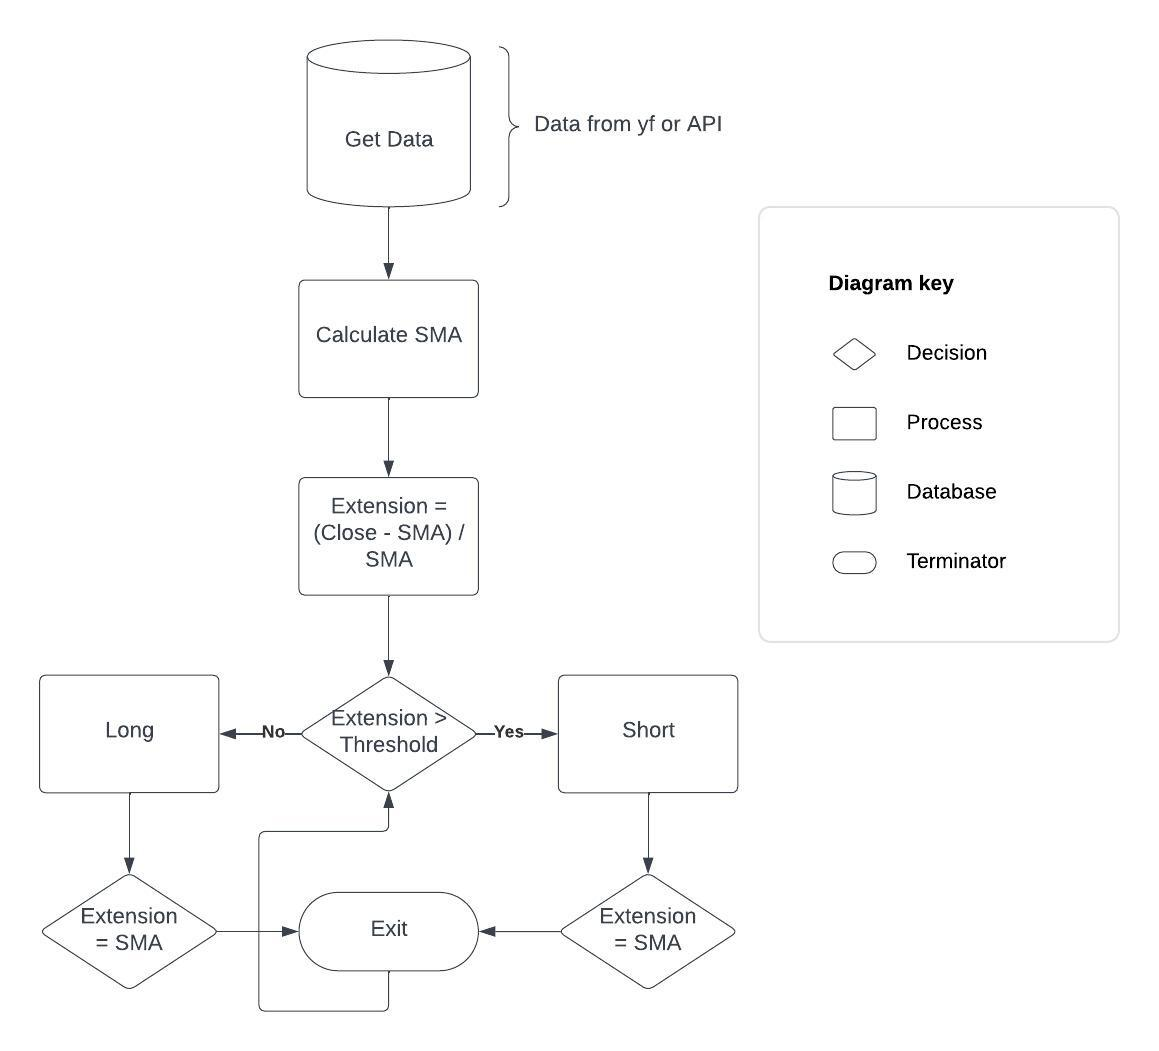

**Updated Strategy**

Our Strategy algorithm will also include an optional filter, this filter adds an exit condition, by doing so we look to limit our downside risk. This is a form of "strategy Optimisation".

This additional filter adds another layer of complexity to our strategy, therefore it is best practice to update our flow diagram. This insures we have a clear idea of our strategies architecture.

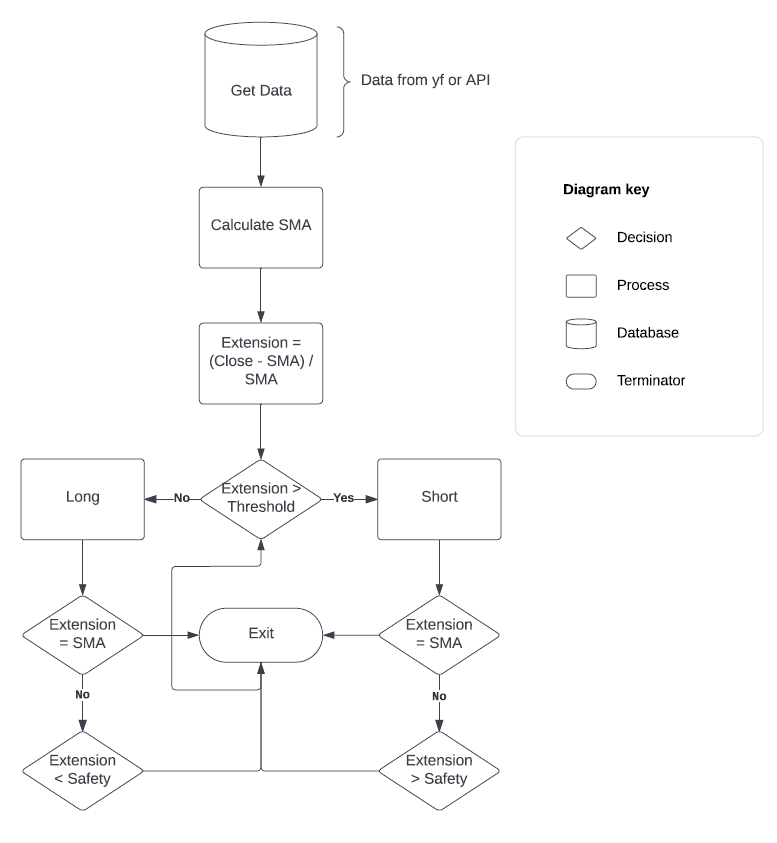



In [4]:
# sma calculation and signals
def SMAMeanReversion(ticker, sma, threshold: float, safety_threshold = 0.25, shorts = False, safety = True,
                     start_date = "2021-01-01", end_date = "2023-12-31"):
  # yfObj is now a class, it has all the yfinance methods
  data = yf.download(ticker, start = start_date, end = end_date)
  # compute and add SMA to data
  data["SMA"] = data["Close"].rolling(sma).mean()
  # this is the percentage difference between the close and the SMA relative to the SMA's value
  # the higher the magnitude the greater the deviation
  data["Extension"] = (data["Close"] - data["SMA"]) / data["SMA"]

  # lets calculate our current position in the market (NAN by default)
  data["position"] = np.nan

  # Safety
  safety_condition_long = (data["Extension"] > -safety_threshold)
  safety_condition_short = (data["Extension"] < safety_threshold)

  # for Long trades (by default)
  # (np.where(condition, [x, y]))
  # for long trades, if the extension is greater than our threshold of x% then we do not enter the trade, momentum > mean reversion
  data["position"] = np.where((data["Extension"] < -1*threshold),
                              1,
                              data["position"]) # returns 0 by defualt in the case we are not long
  # for Short trades (user defined)
  if shorts:
    data["position"] = np.where((data["Extension"] > threshold),
                                -1,
                                data["position"])

  # Exit: if magnitude of extension is small then exit / do not enter market
  data["position"] = np.where(np.abs(data["Extension"]) < 0.01,
                              0,
                              data["position"])

  data["position"] = data["position"].ffill().fillna(0)

  # Safety Implementation
  if safety:
    # we combine conditions here cor clarity, note: "~" = "negation" or "not" operator
    data["position"] = np.where(((data["position"] > 0) & ~safety_condition_long) | ((data["position"] < 0) & ~safety_condition_short),
                                0, data["position"])

  # retutns and statistics
  data["returns"] = data['Close'] / data['Close'].shift(1) # shift brings last value to today
  data["log_returns"] = np.log(data["returns"]) # log returns have a nice property we can just add the returns to get final return

  # we need to use shift as we cannot enter the day the signal is created (repainting error)
  data["strat_returns"] = data["position"].shift(1) * \
    data["returns"]
  data["strat_log_returns"] = data["position"].shift(1) * \
    data["log_returns"]

  # cumulative returns of ticker and strategy (the return curve's)
  data["cum_returns"] = np.exp(data["log_returns"].cumsum()) # returns cumulative simple return (note exp is inverse of log)
  data["strat_cum_returns"] = np.exp(data["strat_log_returns"].cumsum())
  # the return curve peek's (trailing highest account value in backtest)
  # the .cumax() method goes through dataframe values, from the top, row by row replacing the element with it's columns highest value
  data["peak"] = data["cum_returns"].cummax()
  data["strat_peak"] = data["strat_cum_returns"].cummax()
  return data.dropna()


## **Running Strategy** 

However first we must define our algorithm inputs and insensate our strategy function.

Given our Strategy has optional default inputs, we may compare

In [5]:
# inputs
ticker = "AAPL"
smaLag = 50
thresholdmagnitude = 0.1
thresholdsafety = 0.125

# Base Algorithm (Long and Short)
data_base = SMAMeanReversion(ticker, smaLag, thresholdmagnitude, thresholdsafety, shorts = True, safety = False)

# "Optimized" Algorithm (Long and Short)
data_opt = SMAMeanReversion(ticker, smaLag, thresholdmagnitude, thresholdsafety, shorts = True, safety = True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Let's compare the performance of our strategies, It is a common assumption that the "optimized" strategy will outperform our base strategy. We will test the validity of this claim by comparing the dollar equity curves of both strategy algorithm's.

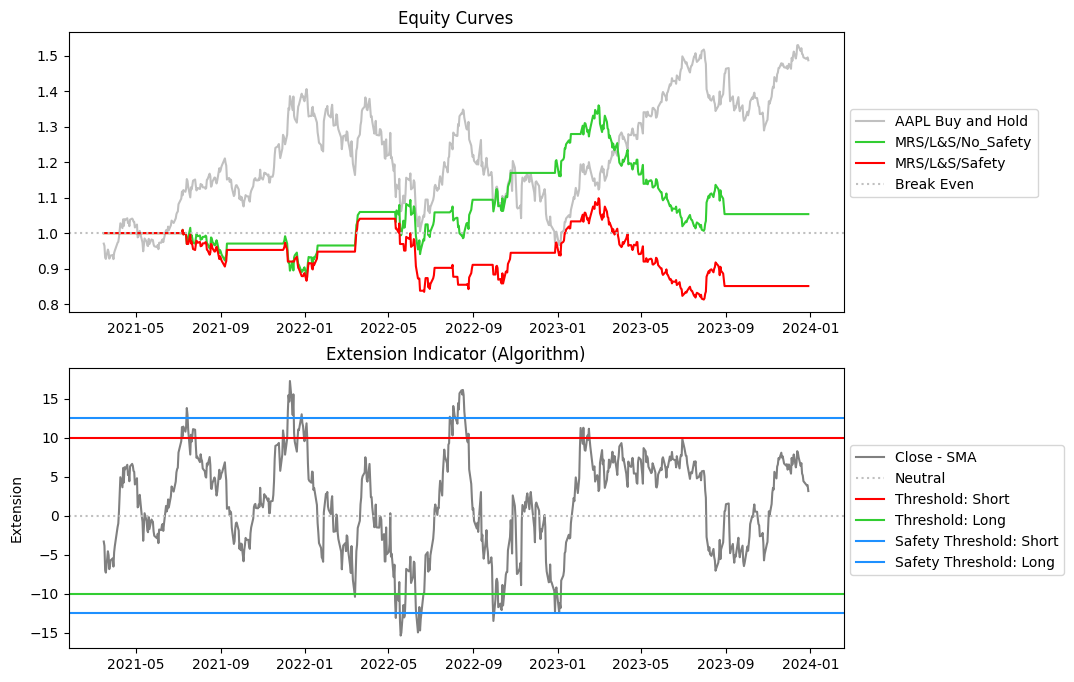

In [49]:
fig1, ax1 = plt.subplots(2, figsize = (10, 8)) # (width, hight)

ax1[0].plot(data_base["cum_returns"], label = f"{ticker} Buy and Hold", color = "silver")
ax1[0].plot(data_base["strat_cum_returns"], label = "MRS/L&S/No_Safety", color = "limegreen")
ax1[0].plot(data_opt["strat_cum_returns"], label = "MRS/L&S/Safety", color = "red")
ax1[0].axhline(1, label = "Break Even", linestyle = "dotted", color = "silver")
ax1[1].plot(data_base["Extension"]*100, color = "gray", label = "Close - SMA")
ax1[1].axhline(0, linestyle = "dotted", label = "Neutral", color = "silver")
ax1[1].axhline(thresholdmagnitude*100, linestyle = "-", label = "Threshold: Short", color = "red")
ax1[1].axhline(-thresholdmagnitude*100, linestyle = "-", label = "Threshold: Long", color = "limegreen")
ax1[1].axhline(thresholdsafety*100, linestyle = "-", label = "Safety Threshold: Short", color = "dodgerblue")
ax1[1].axhline(-thresholdsafety*100, linestyle = "-", label = "Safety Threshold: Long", color = "dodgerblue")
ax1[1].set_ylabel("Extension")
ax1[0].legend(bbox_to_anchor=[1, 0.75])
ax1[0].title.set_text("Equity Curves")
ax1[1].legend(bbox_to_anchor=[1, 0.75])
ax1[1].title.set_text("Extension Indicator (Algorithm)")

As shown in the first plot above, the "optimized" strategy algorithm has not outperformed the base strategy or the symbol, From this sample we can conclude this strategy is not profitable. (note no commissions have been factored, this will further decrease performance)

We may also visualise our trades entries and the duration we were in any one market order.

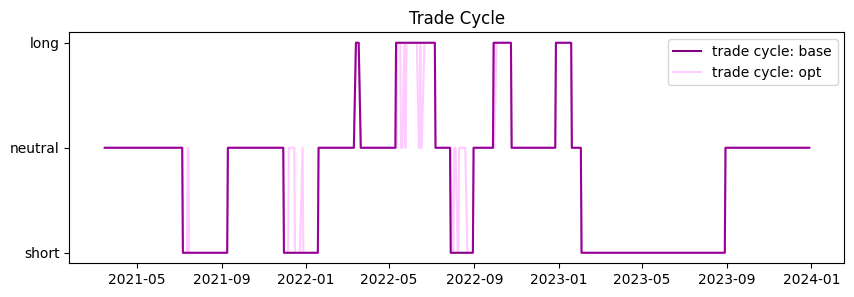

In [59]:
fig2, ax2 = plt.subplots(1, figsize = (10, 3)) # (width, hight)
ax2.plot(data_base["position"], color = "purple", label = "trade cycle: base")
ax2.plot(data_opt["position"], color = "magenta", label = "trade cycle: opt", alpha = 0.2)
ax2.set_yticks([-1, 0, 1])
ax2.set_yticklabels(["short", "neutral", "long"])
ax2.title.set_text("Trade Cycle")
ax2.legend()

## **Strategy Backtest**

In [44]:
def GetStratStates(data, risk_free_rate = 0.02):
  """
  This functions calculates trading strategy metrics against the benchmark
  """

  # let's create two empty dictionaries
  sma_strat, buy_hold_strat = {}, {}

  # Final Returns
  sma_strat["tot_returns"] = np.exp(data["strat_log_returns"].sum()) - 1 # +1 to calculate growth, - 1 to get growth in acount
  buy_hold_strat["tot_returns"] = np.exp(data["log_returns"].sum()) - 1

  # Mean Annual returns
  sma_strat["annual_returns"] = np.exp(data["strat_log_returns"].mean() * 252) - 1
  buy_hold_strat["annual_returns"] = np.exp(data["log_returns"].mean() * 252) - 1

  # Annual Volatility
  sma_strat["annual_volatility"] = data["strat_log_returns"].std() * np.sqrt(252)
  buy_hold_strat["annual_volatility"] = data["log_returns"].std() * np.sqrt(252)

  # Sharpe Ratio
  sma_strat["Sharpe_Ratio"] = (sma_strat["annual_returns"] - risk_free_rate) / sma_strat["annual_volatility"]
  buy_hold_strat["Sharpe_Ratio"] = (buy_hold_strat["annual_returns"] - risk_free_rate) / buy_hold_strat["annual_volatility"]

  # Max Draw Down
  strat_dd = data["strat_peak"] - data["strat_cum_returns"] # difference yields the draw-down from peek
  buy_hold_dd = data["peak"] - data["cum_returns"]
  sma_strat["max_drawdown"] = strat_dd.max()
  buy_hold_strat["max_drawdown"] = buy_hold_dd.max()

  # Days in trade
  sma_strat["#Days_long"] = data.loc[data["position"] > 0, "position"].count()
  sma_strat["#Days_short"] = data.loc[data["position"] < 0, "position"].count()

  # The Dictionary (this stores all our data above)
  stats_dict = {"strats_statistics": sma_strat,
                "benchmark/base_stats": buy_hold_strat}

  return stats_dict


In [46]:
stats_dict_base = GetStratStates(data_base)
df_stats_base = pd.DataFrame(stats_dict_base).round(3)
print(df_stats_base)

stats_dict_opt = GetStratStates(data_opt)
df_stats_opt = pd.DataFrame(stats_dict_opt).round(3)
print("\n", df_stats_opt)

                   strats_statistics  benchmark/base_stats
tot_returns                    0.054                 0.553
annual_returns                 0.019                 0.171
annual_volatility              0.176                 0.273
Sharpe_Ratio                  -0.006                 0.552
max_drawdown                   0.354                 0.440
#Days_long                    76.000                   NaN
#Days_short                  246.000                   NaN

                    strats_statistics  benchmark/base_stats
tot_returns                   -0.149                 0.553
annual_returns                -0.056                 0.171
annual_volatility              0.164                 0.273
Sharpe_Ratio                  -0.466                 0.552
max_drawdown                   0.286                 0.440
#Days_long                    65.000                   NaN
#Days_short                  224.000                   NaN


# **Appendix**

[1]  Strategy Algorithm and Returns Calculations: https://raposa.trade/blog/how-to-build-your-first-mean-reversion-trading-strategy-in-python/ $\\$

[2]  Backtesting Report: https://raposa.trade/blog/how-to-backtest-your-first-trading-strategy-in-python/